In [5]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

In [18]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_classic())
library(gapminder)
options(repr.plot.width=6, repr.plot.height=4)

### Review

In [19]:
load('review.RData')
print(review_dfs)

# A tibble: 3 x 2
  dataset data              
    <dbl> <list>            
1       1 <tibble [100 × 2]>
2       2 <tibble [100 × 2]>
3       3 <tibble [100 × 2]>


For each of these three nested data sets, use linear regression to find an appropriate model relating $x$ and $y$.

In [20]:
# Solution

# Lecture 21: More on regression

In [23]:
by_country = gapminder %>% group_by(country, continent) %>% nest
f <- function(df) lm(lifeExp ~ year, data = df)
gl <- mutate(by_country, model = map(data, f),
             glance = map(model, broom::glance)) %>% 
             unnest(glance)
bad_fit = filter(gl, r.squared < 0.25)

Last lecture we saw that some countries in Africa experienced a sharp drop in life expectancy in the 1990s:

Joining, by = c("country", "continent")


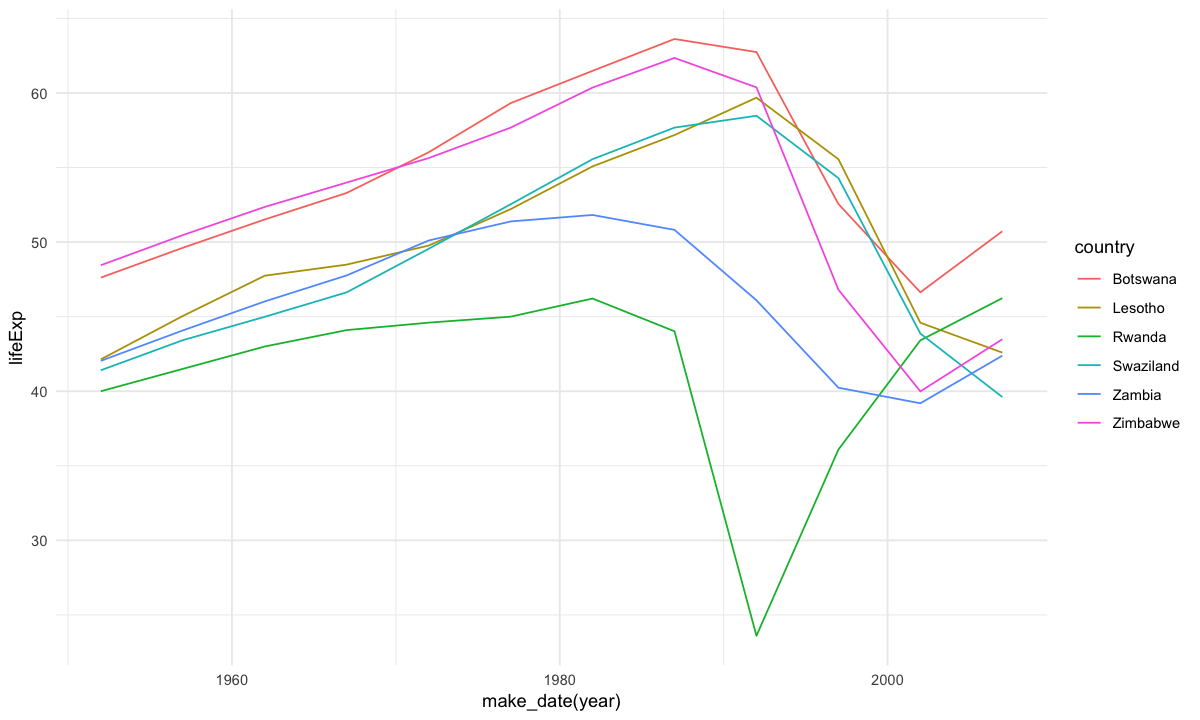

In [250]:
gapminder %>% semi_join(bad_fit) %>% 
    ggplot(aes(make_date(year), lifeExp, color = country)) +
    geom_line()

What is an appropriate model for this data? Clearly a line is not sufficient. We might think about fitting *two* lines per population.
### Exercise
Use the linear model to fit a "two-period" growth model to each of these countries: each country gets one slope and intercept for 1950-1990, and gets another slope and intercept for 1990-present.

In [196]:
# Your code here

Another option for fitting these data is no use a non-linear model:

In [259]:
df <- gapminder %>% semi_join(bad_fit)
print(df)

Joining, by = c("country", "continent")


# A tibble: 72 x 6
   country  continent  year lifeExp     pop gdpPercap
   <fct>    <fct>     <int>   <dbl>   <int>     <dbl>
 1 Botswana Africa     1952    47.6  442308      851.
 2 Botswana Africa     1957    49.6  474639      918.
 3 Botswana Africa     1962    51.5  512764      984.
 4 Botswana Africa     1967    53.3  553541     1215.
 5 Botswana Africa     1972    56.0  619351     2264.
 6 Botswana Africa     1977    59.3  781472     3215.
 7 Botswana Africa     1982    61.5  970347     4551.
 8 Botswana Africa     1987    63.6 1151184     6206.
 9 Botswana Africa     1992    62.7 1342614     7954.
10 Botswana Africa     1997    52.6 1536536     8647.
# ... with 62 more rows


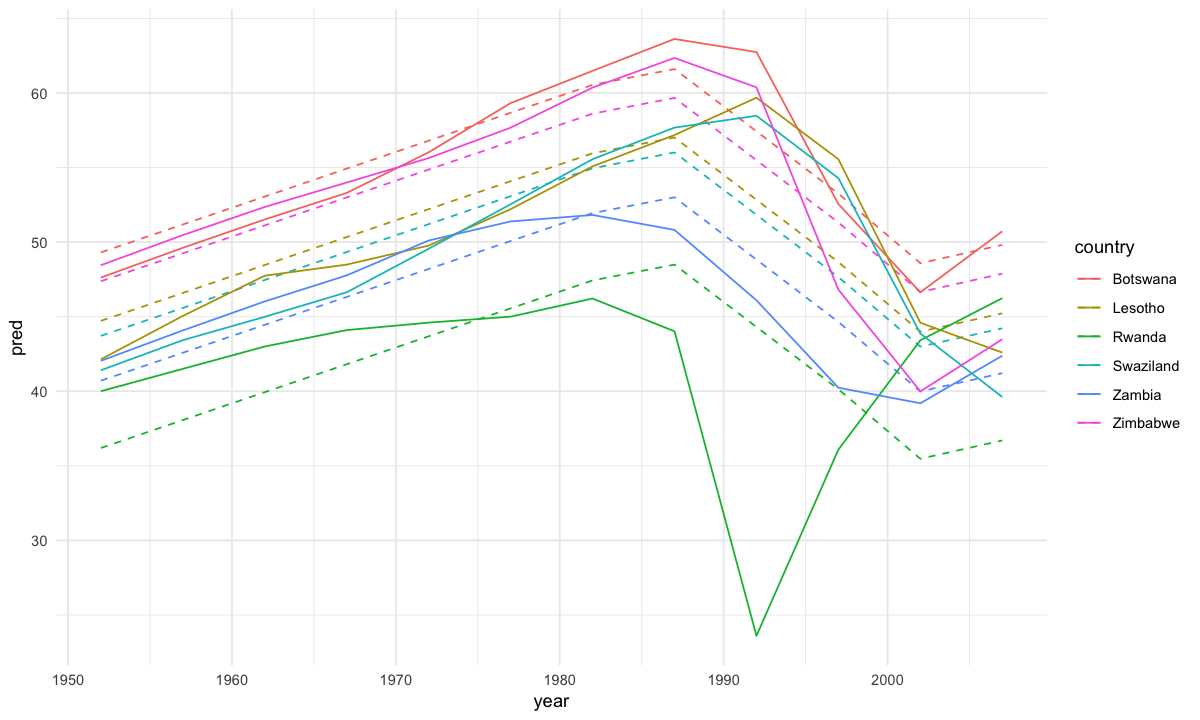

In [270]:
mdl <- lm(lifeExp ~ country + 
                    year * I(year < 1985) + 
                    year * I(year > 1985) * I(year < 2000) +
                    year * I(year > 2000)
          , data=df)
df %>% add_predictions(mdl) %>% ggplot(aes(x=year, colour=country)) + 
    geom_line(aes(y=pred), linetype="dashed") + geom_line(aes(y=lifeExp))

The function `poly(year, 3)` indicates that we have added a third-order polynomial, so that our linear model is now

$$\text{lifeExp} = \text{<country intercept>} + a_1 \text{year} + a_2 \text{year}^2 + a_3 \text{year}^3.$$

(Notice that this model is still linear in $a_i$.)

One downside of this type of approach is interpretability:

In [266]:
summary(mdl)


Call:
lm(formula = lifeExp ~ country + poly(year, 11), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.7546  -1.8848   0.3073   1.4353   9.5441 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       54.5975     1.3192  41.388  < 2e-16 ***
countryLesotho    -4.5904     1.8656  -2.461  0.01704 *  
countryRwanda    -13.1159     1.8656  -7.030 3.36e-09 ***
countrySwaziland  -5.5951     1.8656  -2.999  0.00406 ** 
countryZambia     -8.6012     1.8656  -4.610 2.44e-05 ***
countryZimbabwe   -1.9343     1.8656  -1.037  0.30434    
poly(year, 11)1    1.2701     4.5697   0.278  0.78211    
poly(year, 11)2  -32.6160     4.5697  -7.137 2.25e-09 ***
poly(year, 11)3   -5.1809     4.5697  -1.134  0.26182    
poly(year, 11)4    9.8679     4.5697   2.159  0.03520 *  
poly(year, 11)5   10.0423     4.5697   2.198  0.03221 *  
poly(year, 11)6    1.9145     4.5697   0.419  0.67689    
poly(year, 11)7   -1.7511     4.5697  -0.383  0.70305    
po

## Drops in life expectancy
Which countries experienced the sharpest five-year drops in life expectancy? Can we explain why these occurred?

In [271]:
dlife = gapminder %>% arrange(country, year) %>% group_by(country) %>% 
                      mutate(dlife = c(NA, diff(lifeExp))) %>% arrange(dlife) %>% 
                      mutate(cy = str_c(country, ", ", year)) %>% ungroup
mdlife = mean(dlife$dlife, na.rm = T)

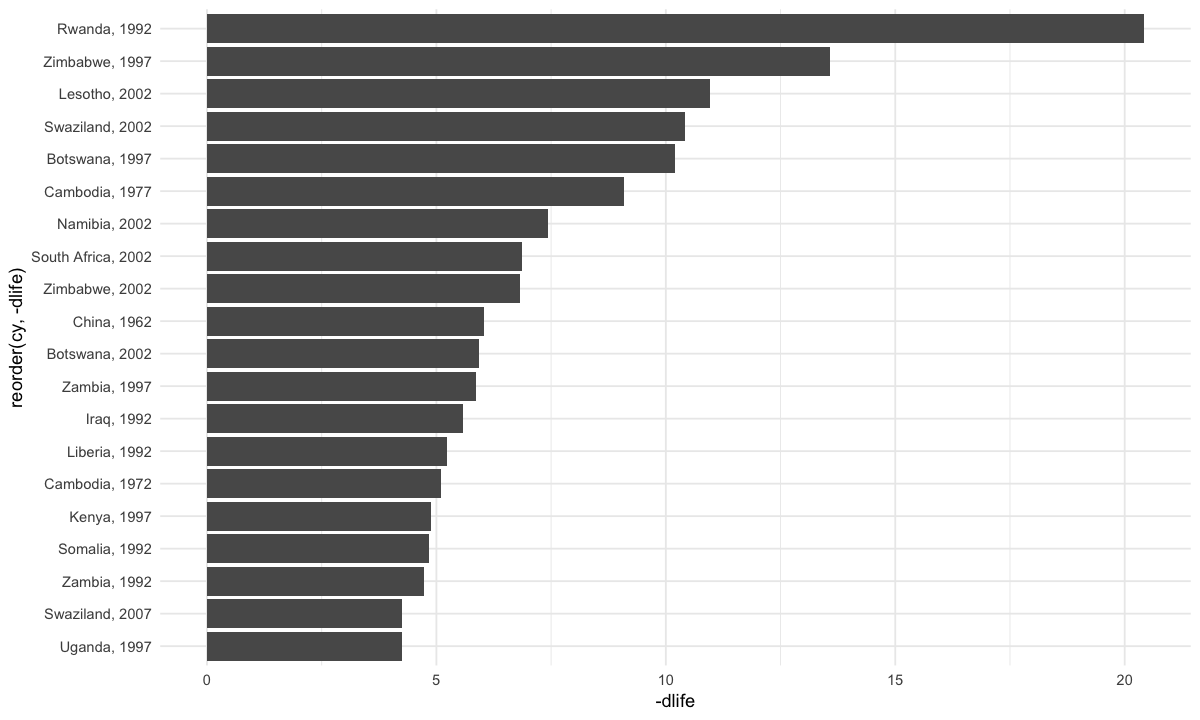

In [273]:
dlife %>% top_n(20, -dlife) %>% 
    ggplot(aes(x = reorder(cy, -dlife), y = -dlife)) + geom_col() + coord_flip()

In most cases these drops in life expectancy appear to be due to the HIV/AIDS epidemic that ravaged sub-Saharan Africa in the late 1990s. To investigate this phenomenon further we will look at an [additional Gapminder data source](https://www.gapminder.org/data/) on the HIV infection rates.

## Reading Microsoft Excel files
The particular data we are interested in come are distributed as a Microsoft Excel spreadsheet. A lot of socio-economic data are distributed in this way, so this gives us a good chance to practice importing Excel data into R. 

<small>(This is probably the only time I will ever say something to the effect of "luckily, the data are in Excel format".)</small>

`tidyverse` conveniently gives us a `readxl` library for importing Excel data into R:

In [5]:
library(readxl)
hiv = readxl::read_xlsx("indicator hiv estimated prevalence% 15-49.xlsx") %>% print

# A tibble: 275 x 34
   `Estimated HIV … `1979.0` `1980.0` `1981.0` `1982.0` `1983.0` `1984.0`
   <chr>               <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>
 1 Abkhazia          NA            NA       NA       NA       NA       NA
 2 Afghanistan       NA            NA       NA       NA       NA       NA
 3 Akrotiri and Dh…  NA            NA       NA       NA       NA       NA
 4 Albania           NA            NA       NA       NA       NA       NA
 5 Algeria           NA            NA       NA       NA       NA       NA
 6 American Samoa    NA            NA       NA       NA       NA       NA
 7 Andorra           NA            NA       NA       NA       NA       NA
 8 Angola             0.0265       NA       NA       NA       NA       NA
 9 Anguilla          NA            NA       NA       NA       NA       NA
10 Antigua and Bar…  NA            NA       NA       NA       NA       NA
# … with 265 more rows, and 27 more variables: `1985.0` <dbl>, `1986.0` <dbl>,
#   `1987.0`

### Exercise
These data are untidy. `gather` them into a tidy format suitable for analysis.

In [7]:
hiv <- hiv %>% gather(key = year, value = 'hiv_pct', -1)

To gain further insight, we can join the HIV data to our other gapminder data. Let us study further the relationship between HIV rate and life expectancy.

In [ ]:
hiv_dlife = dlife %>% ungroup %>% mutate(year = make_date(year), dlife) %>%
    left_join(hiv)
ggplot(hiv_dlife, aes(dlife, hiv_pct)) + geom_point(aes(color = continent)) + 
    geom_smooth(method="lm")

Let us try and quantify this relationship using a linear model:

In [4]:
hiv_gap = gapminder %>% mutate(year = make_date(year)) %>% left_join(hiv)
mod = lm(lifeExp ~ hiv_pct , hiv_gap)
mod %>% summary

ERROR: Error in tbl_vars_dispatch(x): object 'hiv' not found


This says that a 1% increase in the HIV infection percentage leads to a decreased life expectancy of -1.4 years, on average. However, there is a potential problem with this regression fit. To see it, let's look at residuals:

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

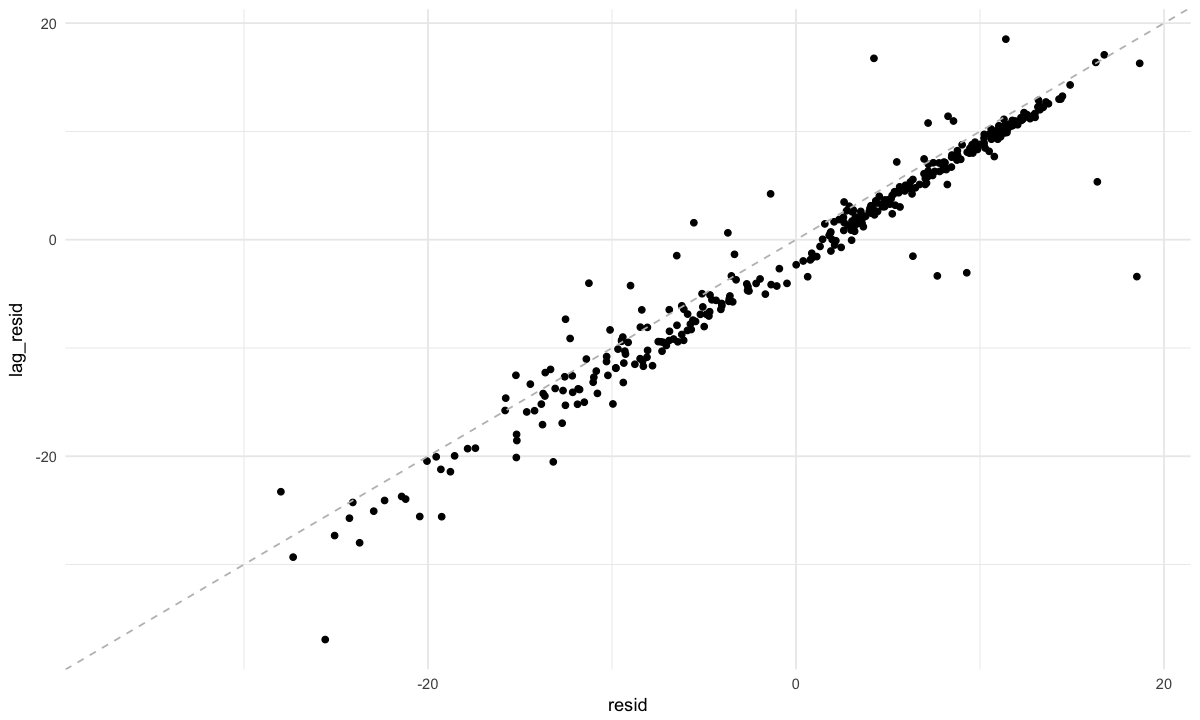

In [33]:
hiv_gap %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
            mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
            geom_abline(slope = 1, linetype = "dashed", colour = "grey")

The linear model assumes that the residuals are *uncorrelated*, whereas here the correlation between each residual and its lag is close to 1. There are a few ways to address this. One is to look at the first-differences model:

In [34]:
hiv_gap_2 = gapminder %>% mutate(year = make_date(year)) %>% left_join(hiv) %>% 
    arrange(country, year) %>% mutate(dlife = c(NA, diff(lifeExp)))
mod = lm(dlife ~ hiv_pct, hiv_gap_2)
mod %>% summary

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”


Call:
lm(formula = dlife ~ hiv_pct, data = hiv_gap_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.4101  -0.5790  -0.1276   0.6275  12.2501 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.57571    0.09228   17.08   <2e-16 ***
hiv_pct     -0.31111    0.01869  -16.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.841 on 480 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.3659,	Adjusted R-squared:  0.3645 
F-statistic: 276.9 on 1 and 480 DF,  p-value: < 2.2e-16


The interpretation of this regression is now different. It says that a one point increase in the HIV percentage causes the 5-year change in life expectancy to decrease by -.31 years.

If we again compare residuals, they look much more like random noise:

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

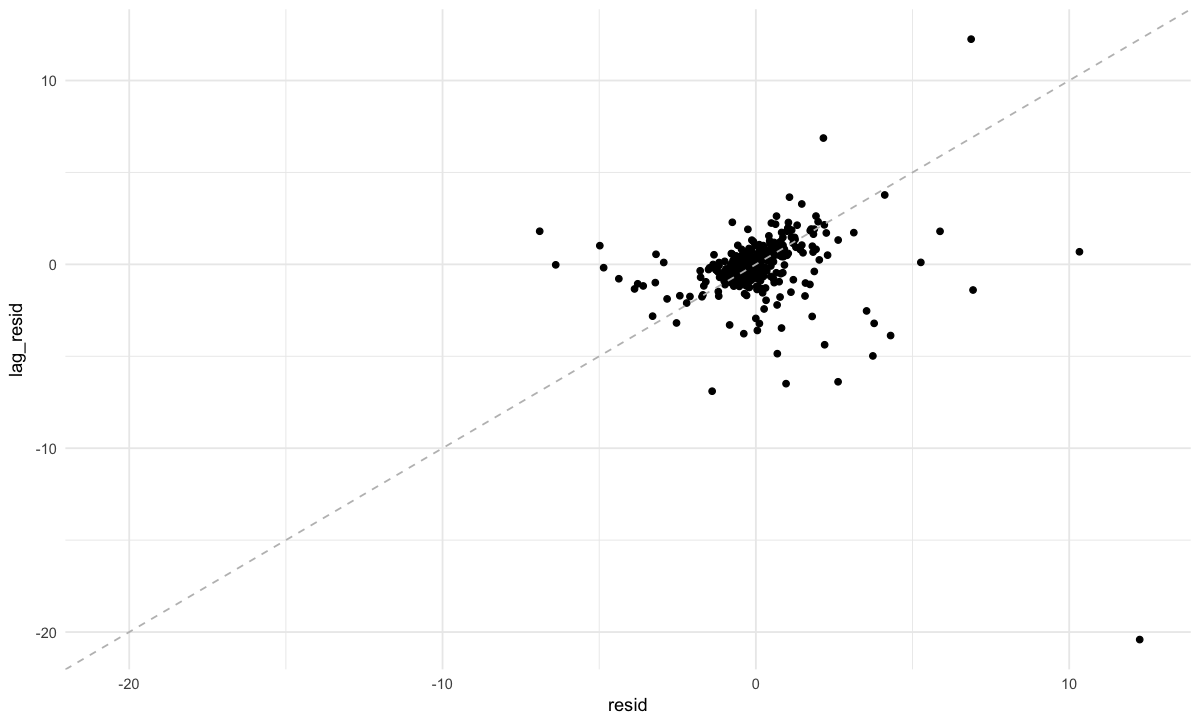

In [35]:
hiv_gap_2 %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
              mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
              geom_abline(slope = 1, linetype = "dashed", colour = "grey") 

### Unsupervised analysis of the gapminder data
Thus for we have been dividing the countries by continent. By this is a little arbitrary. Can we perhaps use an *unsupervised* method to divide them for us?

In [11]:
gap_wide <- gapminder %>% select(country, continent, year, lifeExp) %>% spread(key=year, value=lifeExp)

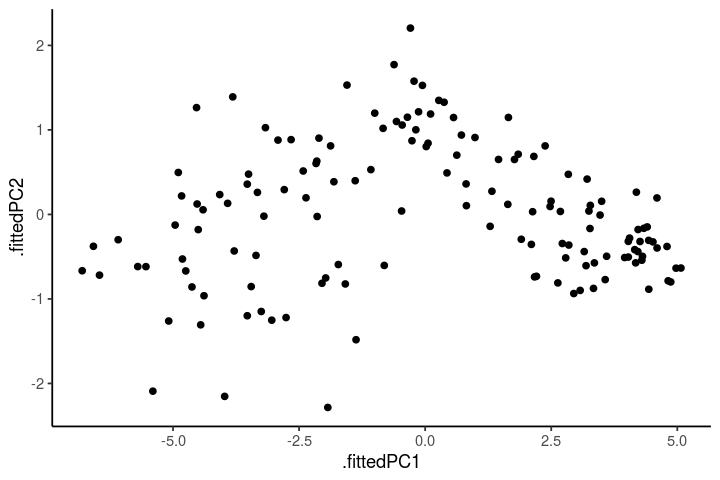

In [24]:
gap_pca <- select(gap_wide, -c(1, 2)) %>%  prcomp(center = T, scale = T) %>% broom::augment(gap_wide)
ggplot(gap_pca) + geom_point(aes(x=.fittedPC1, y=.fittedPC2))